<a href="https://colab.research.google.com/github/piotrwrzodak/UAM-DEEP-LEARNING/blob/master/6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import numpy as np
import torch.nn as nn
import torchvision.models as models
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [19]:
def get_data(batch_size=32):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    return train_loader, val_loader

In [4]:
def get_vgg16_model():
    model = models.vgg16(weights='DEFAULT')
    model.classifier[6] = nn.Linear(4096, 10)
    model = model.to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    return model, loss_fn, optimizer

In [17]:
def get_resnet18_model():
    model = models.resnet18(weights='DEFAULT').to(device)
    for param in model.parameters():
        param.requires_grad = False
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.fc = nn.Sequential(
        nn.Flatten(),
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128, 10),
    )
    model.to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3)

    return model, loss_fn, optimizer

In [6]:
def train_batch(x, y, model, optimizer, loss_fn):
    model.train()
    optimizer.zero_grad()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    return batch_loss.item()

In [7]:
def accuracy(x, y, model):
    model.eval()
    with torch.no_grad():
        prediction = model(x)
        predicted_labels = torch.argmax(prediction, dim=1)
        is_correct = (predicted_labels == y)
    return is_correct.cpu().numpy()

In [20]:
trn_dl, val_dl = get_data()

Files already downloaded and verified
Files already downloaded and verified


tensor(8)


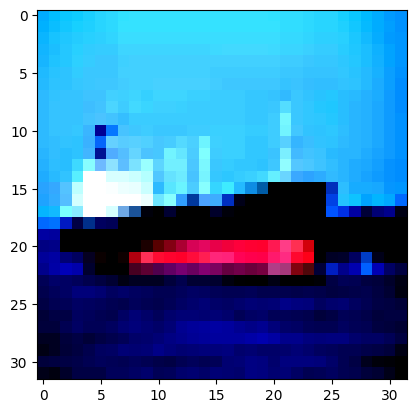

In [9]:
batch = next(iter(trn_dl))
xs, ys = batch
im = xs[0]
label = ys[0]
plt.imshow(im.permute(1,2,0).cpu())
print(label)

In [10]:
def train_model(epoch_number, model, loss_fn, optimizer):
    train_losses, train_accuracies = [], []
    val_accuracies = []

    for epoch in range(epoch_number):
        print(f" epoch {epoch + 1}/5")
        train_epoch_losses, train_epoch_accuracies = [], []
        val_epoch_accuracies = []

        for batch in trn_dl:
            x, y = batch
            x, y = x.to(device), y.to(device)
            batch_loss = train_batch(x, y, model, optimizer, loss_fn)
            train_epoch_losses.append(batch_loss)

        train_epoch_loss = np.mean(train_epoch_losses)

        for batch in trn_dl:
            x, y = batch
            x, y = x.to(device), y.to(device)
            is_correct = accuracy(x, y, model)
            train_epoch_accuracies.extend(is_correct)

        train_epoch_accuracy = np.mean(train_epoch_accuracies)

        for batch in val_dl:
            x, y = batch
            x, y = x.to(device), y.to(device)
            val_is_correct = accuracy(x, y, model)
            val_epoch_accuracies.extend(val_is_correct)

        val_epoch_accuracy = np.mean(val_epoch_accuracies)

        train_losses.append(train_epoch_loss)
        train_accuracies.append(train_epoch_accuracy)
        val_accuracies.append(val_epoch_accuracy)

        print(f"Train Loss: {train_epoch_loss:.4f}, Train Accuracy: {train_epoch_accuracy:.4f}, Validation Accuracy: {val_epoch_accuracy:.4f}")
    return train_accuracies, val_accuracies

In [13]:
def print_accuracy_diagram(model_name, epoch_number, train_accuracies, validation_accuracies):
    plt.plot(epoch_number, train_accuracies, 'bo', label='Training accuracy')
    plt.plot(epoch_number, validation_accuracies, 'r', label='Validation accuracy')
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
    plt.title(f'Training and validation accuracy with {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
    plt.legend()
    plt.grid('off')
    plt.show()

 epoch 1/5
Train Loss: 0.6944, Train Accuracy: 0.8875, Validation Accuracy: 0.8428
 epoch 2/5
Train Loss: 0.3696, Train Accuracy: 0.9308, Validation Accuracy: 0.8602
 epoch 3/5
Train Loss: 0.2421, Train Accuracy: 0.9587, Validation Accuracy: 0.8691
 epoch 4/5
Train Loss: 0.1672, Train Accuracy: 0.9380, Validation Accuracy: 0.8444
 epoch 5/5
Train Loss: 0.1311, Train Accuracy: 0.9719, Validation Accuracy: 0.8692


<ipython-input-13-b7c6f35863c6>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


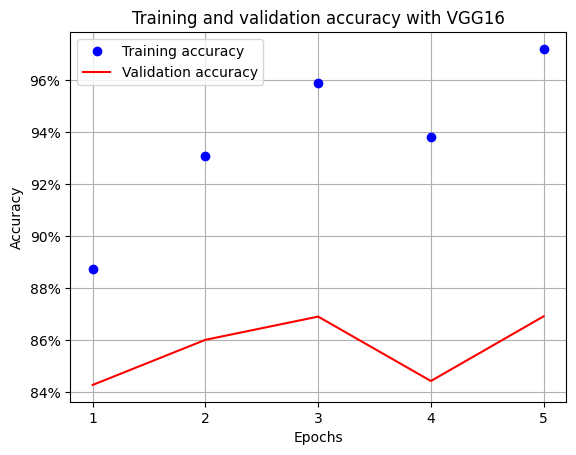

In [15]:
epochs_number = 5
epochs = np.arange(epochs_number) + 1
model, loss_fn, optimizer = get_vgg16_model()
train_accuracies, val_accuracies = train_model(epochs_number, model, loss_fn, optimizer)
print_accuracy_diagram('VGG16', epochs, train_accuracies, val_accuracies)

 epoch 1/5
Train Loss: 0.8303, Train Accuracy: 0.8053, Validation Accuracy: 0.7963
 epoch 2/5
Train Loss: 0.6819, Train Accuracy: 0.8066, Validation Accuracy: 0.7924
 epoch 3/5
Train Loss: 0.6617, Train Accuracy: 0.8041, Validation Accuracy: 0.7887
 epoch 4/5
Train Loss: 0.6475, Train Accuracy: 0.8227, Validation Accuracy: 0.8074
 epoch 5/5
Train Loss: 0.6255, Train Accuracy: 0.8254, Validation Accuracy: 0.8040


<ipython-input-13-b7c6f35863c6>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


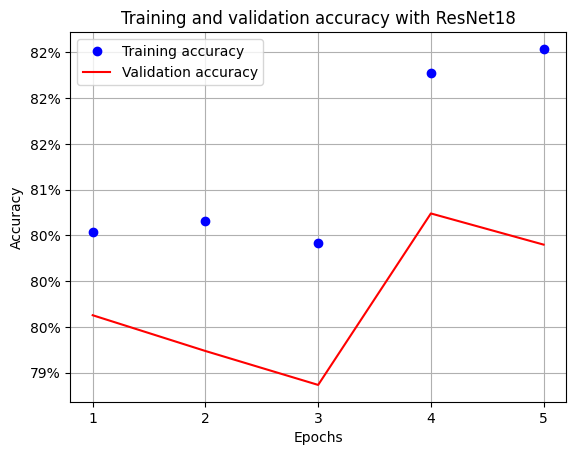

In [21]:
epochs_number = 5
epochs = np.arange(epochs_number) + 1
model, loss_fn, optimizer = get_resnet18_model()
train_accuracies, val_accuracies = train_model(epochs_number, model, loss_fn, optimizer)
print_accuracy_diagram('ResNet18', epochs, train_accuracies, val_accuracies)